In [ ]:
!python -m pip install cityscapesscripts

In [6]:
import os
import torch
import zipfile
import numpy as np
from importlib import reload
from cityscapesscripts.download import downloader 
from os.path import join as pjoin
from torchvision import transforms
from networks.r2unet import R2UNet
from datasets.cityscapes import cityscapesDataset
import matplotlib.pyplot as plt

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="4" 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [4]:
local_path = "./Cityscapes"
pckgs_names = ["gtFine_trainvaltest.zip","leftImg8bit_trainvaltest.zip"]
dir_names = ["gtFine", "leftImg8bit"]

In [5]:
training_data = cityscapesDataset(local_path, split="train")
training_data_raw = cityscapesDataset(local_path, split="train", is_transform=False)
validation_data = cityscapesDataset(local_path, split="val")
test_data = cityscapesDataset(local_path, split="test")

Annotations files processed
Annotations files processed
Annotations files processed
Annotations files processed


In [6]:
dataset_sizes = {
    'train': len(training_data),
    'val': len(validation_data),
    'test': len(test_data),
    'total': len(training_data) + len(validation_data) + len(test_data)
}

dataset_sizes

{'train': 2975, 'val': 500, 'test': 1525, 'total': 5000}

In [7]:
local_path = 'VOCdevkit/VOC2012/' # modify it according to your device
bs = 5
epochs = 10
learning_rate = 0.0002


In [7]:
model = R2UNet().to(device)


In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


#ignore_classes = torch.LongTensor([-1]).to(device)
#weights = torch.ones(20).to(device)
#weights[ignore_classes] = 0.0
loss_f = nn.CrossEntropyLoss(ignore_index = 255)

In [10]:
dataloaders = {
    'train' : torch.utils.data.DataLoader(training_data, batch_size=bs, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(validation_data, batch_size=bs, shuffle=True, num_workers=0)
}

In [26]:
len(dataloaders["val"])

16

In [ ]:
training_data[3][1]

In [ ]:
training_data.label_ids()

In [11]:
def train(model, epochs = epochs, opt = optimizer):
    
    model.train()
    print('Training started')
    print('-' * 10)
    
    for epoch in range(epochs):
        running_corrects = 0
        running_loss = 0.0
        
        for inputs, labels in dataloaders['train']:
            # send inputs and labels to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # reset the gradient
            opt.zero_grad()
            
            # compute loss
            outputs = model(inputs)
            loss = loss_f(outputs, labels)
            preds = torch.argmax(outputs, dim = 1)
            loss.backward()
            opt.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss/dataset_sizes['train']
        print('Epoch {}/{} - train loss = {}'.format(epoch, epochs - 1, epoch_loss))

    return model


In [48]:
dataset_sizes['train']

2975

In [ ]:
model = train(model, epochs)

Epoch 0/9 - train loss = 0.953176204396897

Epoch 1/9 - train loss = 0.7165564631213661

Epoch 2/9 - train loss = 0.6445045435128092

Epoch 3/9 - train loss = 0.5909755590583096

Epoch 4/9 - train loss = 0.4886822928150161

Epoch 5/9 - train loss = 0.3495524222860817

Epoch 6/9 - train loss = 0.3233998321435031

Epoch 7/9 - train loss = 0.30781084855063623

Epoch 8/9 - train loss = 0.28303612886356705

Epoch 9/9 - train loss = 0.26729453921067614

In [38]:
model_path = "models2/fs/"

In [39]:
model.load_state_dict(torch.load(os.path.join(model_path, '10_epochs.pt')))

<All keys matched successfully>

In [40]:
from utils import plot_seg_results

In [41]:
dataloader = torch.utils.data.DataLoader(validation_data, batch_size=5, shuffle=True, num_workers=0)
images, ground_truths = next(iter(dataloader))
outputs = model(images.cuda())
predictions = torch.argmax(outputs.squeeze().cpu(), dim = 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


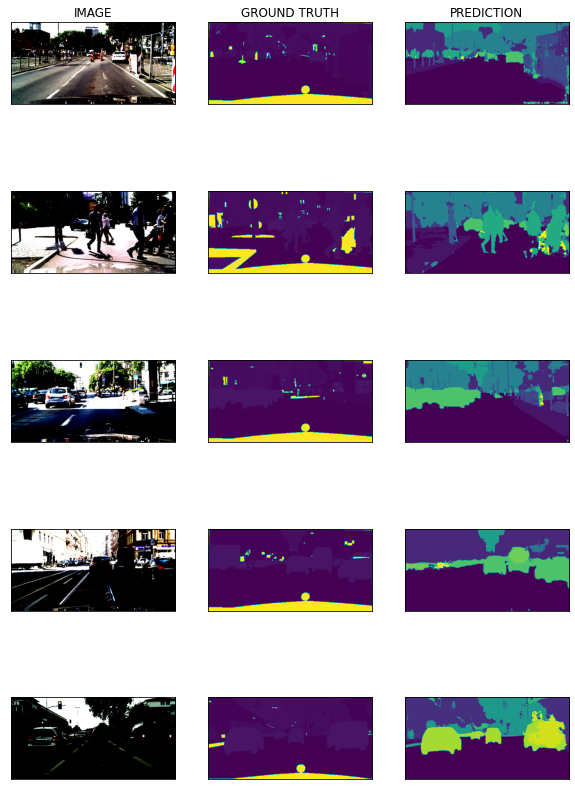

In [42]:
plot_seg_results(images, ground_truths, predictions.detach().numpy())

In [22]:
import importlib
import evaluation
importlib.reload(evaluation)

<module 'evaluation' from '/project/evaluation.py'>

In [23]:
f1_scores = []
dice_coefficients = []
roc_auc_scores = []

In [29]:
true_list = []
pred_list = []
model = model.to(device)

with torch.no_grad():
    for inputs, ground_truths in dataloaders['val']:
        inputs = inputs.to(device)
        outputs = model(inputs)
        pred_list.append(torch.argmax(outputs.detach().cpu(), dim = 1))
        true_list.append(ground_truths)

true_list = torch.flatten(torch.cat(true_list))
pred_list = torch.flatten(torch.cat(pred_list))
eval_report = evaluation.EvaluationReport.from_predictions(true_list, pred_list, 
                                                               labels=list(range(19)))
f1_scores.append(eval_report.f1_score(average="macro"))
dice_coefficients.append(eval_report.dice_coeff(average="macro"))   

In [30]:
f1_scores

[nan, 0.4887]

In [32]:
dice_coefficients

[nan, 0.4887]

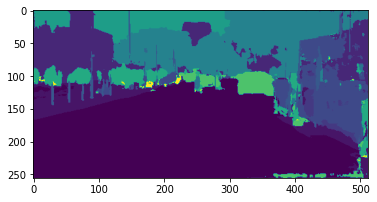

In [43]:
plt.imshow(predictions[0])

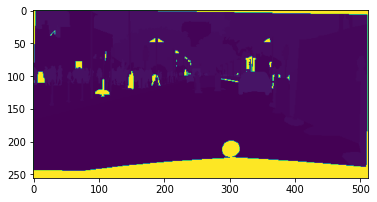

In [44]:
plt.imshow(ground_truths[0])

In [45]:
predictions[0]

tensor([[ 2,  2,  2,  ...,  8,  8,  8],
        [ 8,  8, 10,  ...,  8,  8,  8],
        [ 8,  8, 10,  ...,  8,  8,  8],
        ...,
        [ 0,  0,  0,  ...,  1,  1,  1],
        [ 0,  0,  0,  ...,  1,  1,  1],
        [ 0,  0,  0,  ...,  1,  1,  1]])

In [46]:
ground_truths[0]

tensor([[255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        ...,
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255]])